# The lift curve
**(aka the CAP curve or the gain curve)**

Despite the ROC AUC having a clear interpretation, it is often hard to interpret the ROC curve itself.
In this section we introduce the **lift curve**, which is much easier to interpret and has a clear deterministic relation to the ROC.

## Problem setup: credit scoring

Suppose you are a bank which has 1 million dollars to lend, in batches of $1000, to 1000 borrowers. These people must pay you that money back after one year. 

You have, however, 5000 people asking you for money, and you must decide which 1000 to give the money to.

The main risk here is that you lend money to someone who, for any reasons, does not pay it back (that is, *defaults on the payment*) after one year. There can be several reasons for a person to default: during that year, they lost their job and could not get the necessary money to pay you back; they work with agriculture, and their crops this year were lower than average due to bad weather, so they could not raise the capital to pay you back; they fled the country; etc. 

Your job as a bank is to somehow **score the possible borrowers** and only lend money to those individuals who are less likely to default. This is the standard problem in **credit scoring**. You ask the data scientists in your Credit team to build a classification model to help you make the best decision.

Your data scientists get back to you with a model after one month. Their report says:
> "We have developed a LightGBM model for binary classification. To train this model, we have used our internal database of past loans, over the past 5 years. The target of the model is whether a person has defaulted ($y=1$) on a payment to us during that period or not ($y=0$). There were 38 features employed, which can be split into 3 groups: (1) income & job related (2) previous year financial behavior (on-time payment of credit card bills and other loans) and (3) general personal information. The AUC of the model is 0.77 on the train test and 0.76 on the test set. Our recommendation is to **use the model's output score, sort it from lowest to highest (ie. lowest probability of default to highest probability) and give credit to the 1000 people with lowest score**."

What they recommend is for you to build the following ordered table, and give credit to the top 1000 entries. Call it `df`, a Pandas DataFrame:

|index|person_id | name | prob_default | 
|---|---|---|---|
|0|0123|brad pitt|0.010|
|1|2056|john williams| 0.020|
|2|0091|jackie chan|0.025|
|...|...|...|...|
|4998|9001|bob junior|0.975|
|4999|0918|alice mann|0.982|

The model looks promising. However, it does not answer all your questions. You write an email back to the Credit team with one question:

> Thanks for the good work. If I sort the way you said and only give credit to the first 100 people, how many will I get wrong (defaulted on)? What about the first 500? 1000? Tks

In other words: we want to know how many false negatives (people who will default [$y=1$] which we are wrongly saying are likely to not default [$\hat y =0$]) on the first $n$ people, or equivalently, the percentage of mistakes we will make. 

The simplest way to answer this is with a curve.

### The key question to answer before proceeding

In any problem you work on, you must answer the following question to yourself:
> Which of my entries [people, clients, products...] are "good", and which are "bad"?

In our case, $y=0$ is *good*: no defaults is better than having a default. **This is why we are sorting from low scores (=higher probability of being a 0) to high scores (=higher probability of being a 1)**.

In your use case, it could be the opposite:
> You might try to be solve the problem of identifying which of your employees is likely to leave the company over the next 3 months, in order to talk to them and provide an alternative (this is called an attrition problem). If $y=1$ represents an employee that is likely to leave, then you want to score from high scores to low scores.

### Lift curve I: when low scores are better (sorting from low to high scores)

Use a slight variation of the table above (we will also add more rows to make the example clearer):

|index|person_id | name | prob_default | y_actual|
|---|---|---|---|---|
|0|0123|brad pitt|0.010|0|
|1|2056|john williams| 0.020|0|
|2|0091|jackie chan|0.025|1|
|3|2221|eddie fung|0.029|0|
|4|9301|mark hamill|0.050|1|
|5|8913|lucy liu|0.060|0|
|...|...|...|...|...|
|4998|9001|bob junior|0.975|1|
|4999|0918|alice mann|0.982|1|

Alift, recall that this table is ordered by `prob_default` (in ascending order). Notice that we've made two mistakes: for `jackie chan` and `mark hamill`, we are classifying them as "good payers" (=low probability of default), but their actual target was a 1, ie. a default. They are false negatives, which is exactly what we wanted to avoid.

To account for that mistake, we can build a new columns, called `cumulative_default`, which will simply count the number of defaults acumulated until that row:

`df['cumulative_default'] = df['y_actual'].cumsum()`

|index|person_id | name | prob_default | y_actual|cumulative_default|
|---|---|---|---|---|---|
|0|0123|brad pitt|0.010|0|0|
|1|2056|john williams| 0.020|0|0|
|2|0091|jackie chan|0.025|1|1|
|3|2221|eddie fung|0.029|0|1|
|4|9301|mark hamill|0.050|1|2|
|5|8913|lucy liu|0.060|0|2|
|...|...|...|...|...|...|
|4998|9001|bob junior|0.975|1|150|
|4999|0918|alice mann|0.982|1|151|

Notice that the `cumulative_default` column is non-decreasing. 

Notice that there are 151 defaults. We can obtain this number from `df['cumulative_default'].iloc[-1]` directly, or (in a more inefficient, but more robust way) from `df['y_actual'].sum()`. In either case, we can divide the `cumulative_default` by this number to obtain a `lift` column:
`df['lift'] = df['cumulative_default']/df['y_actual'].sum()`

|index|person_id | name | prob_default | y_actual|cumulative_default|lift|
|---|---|---|---|---|---|---|
|0|0123|brad pitt|0.010|0|0|0|
|1|2056|john williams| 0.020|0|0|0|
|2|0091|jackie chan|0.025|1|1|0.0066|
|3|2221|eddie fung|0.029|0|1|0.0066|
|4|9301|mark hamill|0.050|1|2|0.0132|
|5|8913|lucy liu|0.060|0|2|0.0132|
|...|...|...|...|...|...|...|
|4998|9001|bob junior|0.975|1|150|0.9934|
|4999|0918|alice mann|0.982|1|151|1.0000|

We can also normalize the `index` column (simply dividing each index by the total, 5000) and plot the normalized index vs. the `lift` column on the unit square.

**Visualizing**: we can use `y_test` and `y_test_pred` from before in order to visualize this curve. Let's pretend this is a credit scoring problem.

In [1]:
def build_lift_curve(y_actual, y_pred, 
                     ascending=True,
                     return_ideal_curve=False):
    
    """
    Returns the lift curve from actual (0 or 1) data and
    predicted scores.
    
    Also returns what the ideal lift curve for this problem 
    would be, if return_ideal_curve = True
    """
    
    df = pd.DataFrame({'y_actual': y_actual,
                   'prob_default': y_pred})

    # sort from low to high scores
    df = df.sort_values('prob_default', ascending=ascending)
    
    # build cumulative_default
    df['cumulative_default'] = df['y_actual'].cumsum()
    df['lift'] = df['cumulative_default']/df['y_actual'].sum()

    # create index starting from 0 and normalize
    df = df.reset_index(drop=True).reset_index()
    df['index'] = df['index']/(df['index'].iloc[-1])
    df = df.set_index('index')
    
    if return_ideal_curve:
        df_perfect = df.sort_values('y_actual', ascending=ascending)
        df_perfect['cumulative_default'] = df_perfect['y_actual'].cumsum()
        df_perfect['lift'] = df_perfect['cumulative_default']/df_perfect['cumulative_default'].iloc[-1]
        df_perfect = df_perfect.reset_index(drop=True).reset_index()
        df_perfect['index'] = df_perfect['index']/(df_perfect['index'].iloc[-1])
        df_perfect = df_perfect.set_index('index')
        
        return df['lift'], df_perfect['lift']
    
    return df['lift']

In [7]:
## SAME CODE AS PREVIOUS SECTION
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# create dummy classification problem
X, y = make_classification(n_samples=5000, n_features=10, n_informative=8, n_redundant=1, n_repeated=1, 
                           random_state=10) # for reproducibility

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

model = LogisticRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict_proba(X_train)[:,1]
y_test_pred = model.predict_proba(X_test)[:,1]

In [8]:
lift, ideal_lift = build_lift_curve(y_test, y_test_pred, ascending=True, return_ideal_curve=True)

This is the final table:

In [10]:
pd.DataFrame(lift)

,lift
index,
0.000000,0.000000
0.000667,0.000000
0.001334,0.000000
0.002001,0.000000
0.002668,0.000000
...,...
0.997332,0.994616
0.997999,0.995962
0.998666,0.997308


#### How would a perfect lift curve be here?

Just before we plot: let us understand how a perfect lift curve would compare to ours. In a perfect lift curve, we would make no mistakes: the accumulated default column would be 0 until we reach the first person with $y=1$, and then grow linearly from there. 

#### What about a random classifier?
A random classifier, on the other hand, would linearly go from (0,0) to (1,1) (can you see why?)

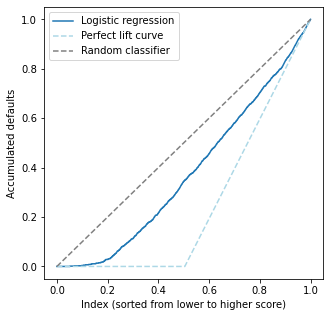

In [12]:
plt.subplots(figsize=(5,5))

# lift curve from the model
lift.plot(label='Logistic regression')

# perfect lift
ideal_lift.plot(xlabel='Index (sorted from lower to higher score)', ylabel='Accumulated defaults', 
                       label='Perfect lift curve', linestyle='--', color='lightblue')

# random lift
x = np.linspace(0,1)
plt.plot(x,x, linestyle='--', label='Random classifier', color='gray')

plt.legend()
plt.show()

**Interpretation**:

Notice that the best possible curve is the lowest, whereas the worst one is the 45 degree diagonal. Our model is intermediate, not too low nor too high. The lift curve is monotonic by construction.
* Our model is good for *low scores*: the curve starts out flat but quickly starts to grow, meaning our model is making mistakes. 
* It is worst for *medium scores*, where the curve grows almost parallel to the random classifier one
* For high scores, where the ideal curve is slanted, the model performs well - it tends to grow very fast in that area.

**The lift curve is useful because it allows us to see how the model behaves across the whole data**. It gives us an interpretable curve which tells us how well we perform for entries with low/medium/high scores.

### Lift curve II: when high scores are better (sorting from high to low scores)

This case is exactly the opposite from the previous one. 

> A possible use case is in **product recommendation**. Suppose we have a model for whether a customer will be interested ($y=1$) or not ($y=0$) in a product, which will be recommended to them in our company's homepage. Then, we want to recommend the product to the clients with highest propensity to like the product, ie. those with higher score.

In [13]:
lift, ideal_lift = build_lift_curve(y_test, y_test_pred,
                                    ascending=False, # the only change is here
                                    return_ideal_curve=True)

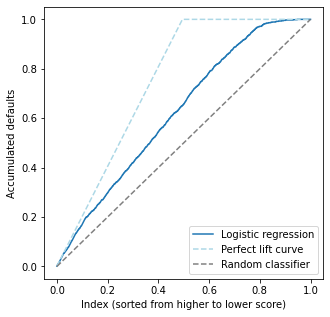

In [14]:
plt.subplots(figsize=(5,5))

# lift curve from the model
lift.plot(label='Logistic regression')

# perfect lift
ideal_lift.plot(xlabel='Index (sorted from higher to lower score)', ylabel='Accumulated defaults', 
                       label='Perfect lift curve', linestyle='--', color='lightblue')

# random lift
x = np.linspace(0,1)
plt.plot(x,x, linestyle='--', label='Random classifier', color='gray')

plt.legend()
plt.show()

**Interpretation**: of course, since we are using the exact same data as before, the conclusions must be the same. This curve is exactly the previous one, upside down.

### Area under the lift curve & its relation to ROC AUC

**The lift curves must be analyzed together with the ROC AUC**. It turns out they are both complementary and interpretable, providing a full picture of what is happening.

We now state (and prove in the Appendix below) a very interesting result relating it to the ROC AUC: **one of them uniquely defines the other**, so the area under the lift curve doesn't really matter. We can use the ROC AUC instead.

Let $\pi$ denote the proportion of the minority class to the total amount of points. Then

$$\boxed{\binom{\mbox{area under}}{\mbox{lift curve}} = \frac{\pi}{2} + (1-\pi) \times \mathrm{AUC}}\qquad \mbox{(high to low scores)}$$

#### Numerically checking this

Let us use the DataFrame defined above (which has the lift with scores from high to low).

We want to compare the area under the lift curve (which has no unique name; let us call it $\mathrm{AUL}$ for now) with the expression $\pi_1/2 +(1-\pi_1) \mathrm{AUC}$.

In [19]:
from sklearn.metrics import auc  # this is not roc_auc_score; it is just a function for numerical integration
from sklearn.metrics import roc_auc_score

pi1 = y_test.sum()/len(y_test) # proportion of 1's in the test dataset
print("Proportion of positive class (pi1): {0:.3f}".format(pi1))
AUL = auc(x=lift.index, y=lift)
auc_ = roc_auc_score(y_test, y_test_pred)
print("\nRaw metrics:\n > AUL = {0:.3f}\n > AUC = {1:.3f}".format(AUL, auc_))

AUL_calc = pi1/2 + (1-pi1) * auc_
print("\nCalculated AUL: {0:.3f}".format(AUL_calc))
print(" > Difference between AUL and calculated version: {0:.4f}".format(np.abs(AUL-AUL_calc)))

Proportion of positive class (pi1): 0.495

Raw metrics:
 > AUL = 0.624
 > AUC = 0.746

Calculated AUL: 0.624
 > Difference between AUL and calculated version: 0.0004


We can see that indeed both are very close (difference in the fourth decimal place), as expected!

## The Gini coefficient

A quantity related to both the ROC AUC and the area under the lift curve is the **Gini coefficient**.

![](../images/lift/gini.png)

(image modified from [this post](https://www.listendata.com/2019/09/gini-cumulative-accuracy-profile-auc.html))

One can easily show (using a similar logic to that of the calculations we do in the Appendix) that 

$$\boxed{\mathrm{Gini} = 2\mathrm{AUC}-1}$$

Hence, this is yet another metric which coincides with the ROC AUC.

# Appendix

**Proposition [equivalence of AUL and ROC AUC]**. Consider the lift curve II above (which is sorted from high to low scores). Let $\mathrm{AUL}$ denote the area under the lift curve, and let $\mathrm{AUC}$ denote the ROC AUC. Let $\pi_1 = \mathbb{P} (y=1)$ denote the fraction of the positive class. Then

$$\boxed{\mathrm{AUL} = \frac{\pi_1}{2} + (1-\pi_1) \mathrm{AUC}}\qquad \mbox{(high to low scores)}$$

**Proof**: let us translate our construction of the lift curve into the language of probability. The Y axis contains the proportion of points correctly classified as 1, i.e. $\mathbb P(\hat y = 1|y=1)$ which is just the true positive rate. We have seen in the Appendix for the ROC curve that, for a fixed threshold $\lambda$, 

$$\mathrm{TPR}(\lambda) = 1 - F_1(\lambda)$$

where $F_1(\lambda) = \mathbb P (f(X) \leq \lambda | Y=1)$ is the CDF for the score $f(X)|Y=1$. Hence, we let $y(\lambda) = 1 - F_1(\lambda)$ be our Y axis. For the X axis, it represents the proportion ($\mathbb P$) of points with decreasing ($\geq \lambda$) score ($f(X)$). Hence, $x = \mathbb P (f(X) \geq \lambda) = 1 - F(\lambda)$ where the CDF $F(\lambda)$ is that of the unconditional score: 

$$F(\lambda) = \mathbb P (f(X) < \lambda),$$ 

which can also be written in terms of the conditionals $F_i$ via 

$$
\begin{align}F(\lambda) &=  \mathbb P (f(X) < \lambda) = \mathbb P (f(X) < \lambda|Y=1) \mathbb{P} (Y=1) + \mathbb P (f(X) < \lambda|Y=0) \mathbb{P}(Y=0)\\
&= \pi_1 F_1(\lambda) + \pi_0 F_0 (\lambda)\end{align}.
$$

Here $\pi_1 + \pi_0 = 1$ are the proportions of $Y=1$ and $Y=0$. We have thus written the lift curve as

$$\begin{cases}x(\lambda) &=& 1 - F(\lambda) = 1 - \pi_1 F_1(\lambda) - \pi_0 F_0(\lambda)\\
y(\lambda) &=& 1 - F_1(\lambda)\end{cases}$$

To calculate $\mathrm{AUL}$, ideally we would like to write $y$ as a function of $x$ and integrate. This is possible if we invert $\lambda = \lambda(x)$ and plug it into the expression for $y$. This is hard since $\lambda$ appears both as the argument of $F_0$ and $F_1$. Instead, what we can do is to *write $x$ as a function of $y$ instead* and calculate the integral $\int x dy$ instead of $\int y dx$. These integrals are not the same, but they will be related as we show below. 

We have $\lambda = F_1^{-1}(1-y)$. Plugging this into the equation for $x$ yields (calling $G(x)$ the lift curve and $G^{-1}(y)$ its inverse:

$$
\begin{align}
x \equiv G^{-1}(y) &= 1 - \pi_1 F_1 (F_1^{-1}(1-y)) - \pi_0 F_0 (F_1^{-1}(1-y)) \\
&= 1 - \pi_1(1-y) - \pi_0 F_0(F_1^{-1}(1-y)).
\end{align}
$$

In the Appendix for the ROC curve we saw that we could write it as $y = R(x) = 1 - F_1(F_0^{-1}(1-x))$. This is almost what we have, but the roles of $F_1$ and $F_0$ are shifted. We can actually invert this expression to get 

$$x \equiv R^{-1}(y) = 1 - F_0(F_1^{-1}(1-y)),$$ 

which matches nicely with the RHS above. Hence 

$$
\begin{align}
G^{-1}(y) &= 1 - \pi_1 (1-y) - \pi_0 (1 - R^{-1}(y))\\
&=\pi_1 y + \pi_0 R^{-1}(y)\\
\Rightarrow \int_0^1 G^{-1}(y)dy  &= \frac{\pi_1}{2} + \pi_0 \int_0^1R^{-1}(y)dy
\end{align}
$$

Now, both the ROC and lift curve live inside the unit square $[0,1]\times[0,1]$, which has area equal to 1, and have endpoints in $(0,0)$ and $(1,1)$. For any such function,

$$\int_0^1 f(x) dx + \int_0^1 f^{-1}(y) dy = 1.$$

We can then rewrite the equality above using $\mathrm{AUC}$ and $\mathrm{AUL}$:

$$(1-\mathrm{AUL}) = \frac{\pi_1}{2} + \pi_0 (1-\mathrm{AUC});$$

using that $\pi_0 = 1 - \pi_1$ and simplifying yields

$$\mathrm{AUL} = \frac{\pi_1}{2} + (1-\pi_1) \mathrm{AUC}$$
as claimed.

**Problem**: using the exact same logic as above (or just good old geometry) prove that for the lift curve I it holds that

$$\boxed{\mathrm{AUL} = 1 - \left[\frac{\pi_1}{2} + (1-\pi_1) \mathrm{AUC}\right]}\qquad \mbox{(low to high scores)}$$

## References
[1] Chris J. Lloyd, *A Note on the Area under the Lifts Chart*. International Journal of Statistics in Medical Research, 2018, 7, 66-69 

[2] Max Kuhn, Kjell Johnson, *Applied Predictive Modeling*. Springer, 2016, pp. 265-266